## IntentLens: Comparative Study of Classical and Neural Embeddings for Banking Query Classification

In [1]:
# BLOCK 1 - DRIVE + PROJECT DIR + ENV CHECK
from google.colab import drive
drive.mount('/content/drive')

import os, sys, time, platform
project_dir = "/content/drive/MyDrive/GenAI_Capstone"
os.makedirs(project_dir, exist_ok=True)
%cd $project_dir

# quick environment info (useful for debugging)
print("Python", sys.version.split()[0])
print("Platform:", platform.platform())
try:
    import torch
    print("PyTorch:", torch.__version__, "CUDA available:", torch.cuda.is_available())
except Exception as e:
    print("PyTorch not installed yet.")


Mounted at /content/drive
/content/drive/MyDrive/GenAI_Capstone
Python 3.12.12
Platform: Linux-6.6.105+-x86_64-with-glibc2.35
PyTorch: 2.8.0+cu126 CUDA available: False


In [1]:
# RESUME BLOCK A - Mount + cd
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/GenAI_Capstone

# RESUME BLOCK B - Load saved artifacts and sentence-transformer
import joblib
from sentence_transformers import SentenceTransformer
import os

art_dir = os.path.join("/content/drive/MyDrive/GenAI_Capstone","artifacts")
tfidf = joblib.load(os.path.join(art_dir, "tfidf_vectorizer.pkl"))
models = {}
models['LogisticRegression'] = joblib.load(os.path.join(art_dir, "model_tfidf_lr.pkl"))
models['LinearSVC'] = joblib.load(os.path.join(art_dir, "model_tfidf_svm.pkl"))
models['RandomForest'] = joblib.load(os.path.join(art_dir, "model_tfidf_rf.pkl"))
models['ST+Logistic'] = joblib.load(os.path.join(art_dir, "model_st_logistic.pkl"))
st_model = SentenceTransformer("all-MiniLM-L6-v2")
print("Artifacts loaded.")


In [2]:
# BLOCK 2 - INSTALL DEPENDENCIES
!pip -q install datasets scikit-learn sentence-transformers joblib matplotlib seaborn transformers

# small inline import test (will raise if install fails)
import sklearn, matplotlib, joblib
print("sklearn", sklearn.__version__, "matplotlib", matplotlib.__version__)


sklearn 1.6.1 matplotlib 3.10.0


In [5]:
print("Loading PolyAI/banking77 dataset...")

from datasets import load_dataset
import pandas as pd

# Load dataset (script-free version)
dataset = load_dataset("banking77", "default")

train = dataset["train"]
test = dataset["test"]

# Convert to DataFrame
df_train = pd.DataFrame(train)
df_test = pd.DataFrame(test)

# Map numeric labels to text labels
label_names = train.features["label"].names
df_train["label_text"] = df_train["label"].apply(lambda x: label_names[x])
df_test["label_text"] = df_test["label"].apply(lambda x: label_names[x])

print("Sample record:")
print(df_train.head(2))


Loading PolyAI/banking77 dataset...


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/298k [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/93.9k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/10003 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3080 [00:00<?, ? examples/s]

Sample record:
                                                text  label    label_text
0                     I am still waiting on my card?     11  card_arrival
1  What can I do if my card still hasn't arrived ...     11  card_arrival


Total classes: 77


,count
label,
0,159
1,110
2,126
3,87
4,127
5,171
6,181
7,156
8,157


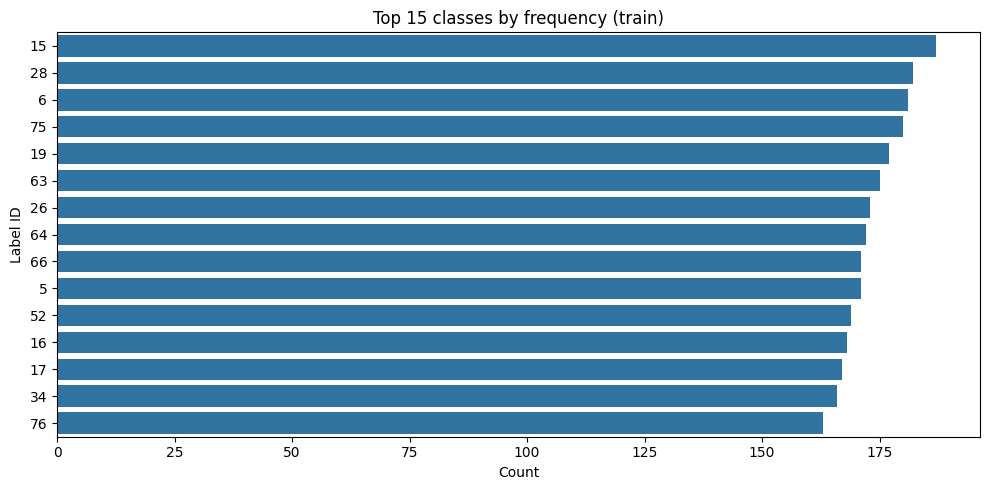

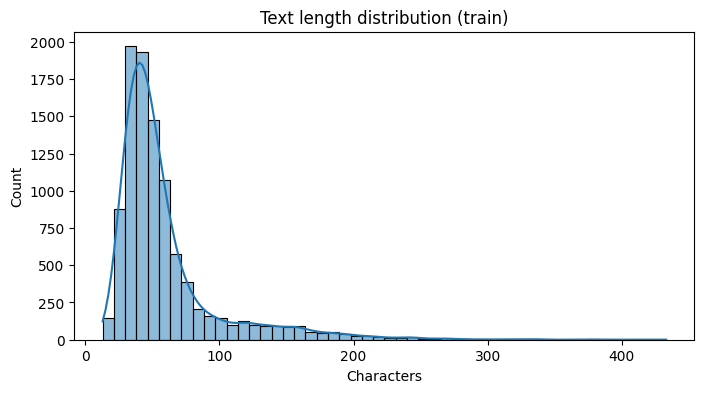


Example texts from frequent classes:

--- label 15 ---
['I noticed that i got charged extra for using the card.'
 'I think a fee was applied for paying with a card.'
 'I wanted to know why i got an additional fee when i use my card.']

--- label 28 ---
["My accounts been charged a payment for something I didn't make."
 'What is this direct debit in my statement?'
 "There is a direct debit charge on my account that I don't recognize."]

--- label 6 ---
['my check or cash deposit has not shown up'
 "Why isn't my cheque deposit showing on my account?  I though it would be faster and would like to to look into it and help."
 "My cheque deposit didn't seem to work."]

--- label 75 ---
['i did not get any money but still was charged'
 'I was not distributed all of cash that I requested'
 'The ATM gave me less cash than requested']


In [7]:
# BLOCK 4 - EDA
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

# df_train and df_test already defined in Block 3

# Label distribution
label_counts = df_train['label'].value_counts().sort_index()
print("Total classes:", label_counts.shape[0])
display(label_counts.head(10))

# Plot top classes
topk = 15
top_classes = label_counts.sort_values(ascending=False).head(topk)

plt.figure(figsize=(10,5))
sns.barplot(
    x=top_classes.values,
    y=[str(i) for i in top_classes.index],
)
plt.title(f"Top {topk} classes by frequency (train)")
plt.xlabel("Count")
plt.ylabel("Label ID")
plt.tight_layout()
plt.show()

# Text length distribution
df_train["char_len"] = df_train["text"].str.len()

plt.figure(figsize=(8,4))
sns.histplot(df_train["char_len"], bins=50, kde=True)
plt.title("Text length distribution (train)")
plt.xlabel("Characters")
plt.show()

# Show examples from common classes
print("\nExample texts from frequent classes:")
sample_classes = label_counts.sort_values(ascending=False).head(4).index

for c in sample_classes:
    print("\n--- label", c, "---")
    print(df_train[df_train["label"] == c]["text"].sample(3).values)


In [8]:
# BLOCK 5 - PREPROCESSING
import re
def clean_text(s):
    s = s.lower()
    s = re.sub(r"https?://\S+", " ", s)  # remove urls
    s = re.sub(r"[^a-z0-9\s\?\!\.]+", " ", s)  # keep basic punct + alnum
    s = re.sub(r"\s+", " ", s).strip()
    return s

# Apply cleaning lazily (transformers/embeddings are robust, but TF-IDF benefits)
df_train['clean_text'] = df_train['text'].apply(clean_text)
df_test['clean_text'] = df_test['text'].apply(clean_text)

# Quick sanity check
print(df_train[['text','clean_text']].sample(3).to_dict(orient='records'))


[{'text': "I don't need to transfer anymore and I want to cancel it.", 'clean_text': 'i don t need to transfer anymore and i want to cancel it.'}, {'text': 'How much are the rates of exchange?', 'clean_text': 'how much are the rates of exchange?'}, {'text': 'My daughter would like a card from my account?  Can I do this?', 'clean_text': 'my daughter would like a card from my account? can i do this?'}]


In [9]:
# BLOCK 6 - TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(stop_words='english', max_features=10000, ngram_range=(1,2))
X_train_tfidf = tfidf.fit_transform(df_train['clean_text'])
X_test_tfidf = tfidf.transform(df_test['clean_text'])
y_train = df_train['label'].values
y_test = df_test['label'].values

print("TF-IDF shapes:", X_train_tfidf.shape, X_test_tfidf.shape)


TF-IDF shapes: (10003, 10000) (3080, 10000)


In [10]:
# BLOCK 7 - TRAIN CLASSICAL MODELS
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
import time

models = {}

# Logistic Regression
t0 = time.time()
lr = LogisticRegression(max_iter=2000, n_jobs=-1)
lr.fit(X_train_tfidf, y_train)
print("LR train time:", round(time.time()-t0,1), "s")
models['LogisticRegression'] = lr

# Linear SVM
t0 = time.time()
svm = LinearSVC(max_iter=20000)
svm.fit(X_train_tfidf, y_train)
print("SVM train time:", round(time.time()-t0,1), "s")
models['LinearSVC'] = svm

# Random Forest (smaller for speed)
t0 = time.time()
rf = RandomForestClassifier(n_estimators=200, n_jobs=-1)
rf.fit(X_train_tfidf, y_train)
print("RF train time:", round(time.time()-t0,1), "s")
models['RandomForest'] = rf


LR train time: 8.4 s
SVM train time: 1.4 s
RF train time: 81.7 s


In [11]:
# BLOCK 8 - EVALUATE CLASSICAL MODELS
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np

def evaluate_model(name, model, X_test, y_test):
    preds = model.predict(X_test)
    acc = accuracy_score(y_test, preds)
    print(f"\n{name} Accuracy: {acc:.4f}")
    print(classification_report(y_test, preds, zero_division=0))
    return preds

results = {}
for name, model in models.items():
    preds = evaluate_model(name, model, X_test_tfidf, y_test)
    results[name] = preds



LogisticRegression Accuracy: 0.8221
              precision    recall  f1-score   support

           0       0.97      0.93      0.95        40
           1       1.00      0.97      0.99        40
           2       0.97      0.97      0.97        40
           3       0.92      0.85      0.88        40
           4       1.00      0.90      0.95        40
           5       0.64      0.80      0.71        40
           6       0.80      0.90      0.85        40
           7       0.91      0.78      0.84        40
           8       0.86      0.95      0.90        40
           9       1.00      0.97      0.99        40
          10       0.83      0.60      0.70        40
          11       0.71      0.85      0.77        40
          12       0.72      0.82      0.77        40
          13       0.90      0.93      0.91        40
          14       0.67      0.82      0.74        40
          15       0.80      0.80      0.80        40
          16       0.60      0.72      0.66 

In [12]:
# BLOCK 9 - NEURAL EMBEDDINGS (SentenceTransformer) + Logistic
from sentence_transformers import SentenceTransformer
import numpy as np
import time
st_model = SentenceTransformer("all-MiniLM-L6-v2")  # small & fast

# encode (this takes time; progress shown in notebook)
t0 = time.time()
X_train_emb = st_model.encode(df_train['text'].tolist(), show_progress_bar=True, batch_size=64)
X_test_emb = st_model.encode(df_test['text'].tolist(), show_progress_bar=True, batch_size=64)
print("Embedding time:", round(time.time()-t0,1), "s")

# logistic on embeddings
t0 = time.time()
lr_emb = LogisticRegression(max_iter=2000, n_jobs=-1)
lr_emb.fit(X_train_emb, y_train)
print("LR on embeddings train time:", round(time.time()-t0,1), "s")
models['ST+Logistic'] = lr_emb

# Evaluate
preds_emb = lr_emb.predict(X_test_emb)
print("ST+Logistic Accuracy:", accuracy_score(y_test, preds_emb))
print(classification_report(y_test, preds_emb, zero_division=0))
results['ST+Logistic'] = preds_emb


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/157 [00:00<?, ?it/s]

Batches:   0%|          | 0/49 [00:00<?, ?it/s]

Embedding time: 122.0 s
LR on embeddings train time: 3.5 s
ST+Logistic Accuracy: 0.9081168831168831
              precision    recall  f1-score   support

           0       1.00      0.90      0.95        40
           1       0.98      1.00      0.99        40
           2       0.98      1.00      0.99        40
           3       1.00      0.95      0.97        40
           4       1.00      0.88      0.93        40
           5       0.76      0.78      0.77        40
           6       0.93      0.95      0.94        40
           7       0.87      0.82      0.85        40
           8       0.95      1.00      0.98        40
           9       0.93      1.00      0.96        40
          10       0.94      0.85      0.89        40
          11       0.88      0.88      0.88        40
          12       0.88      0.90      0.89        40
          13       0.89      1.00      0.94        40
          14       0.86      0.95      0.90        40
          15       0.81      0.95  

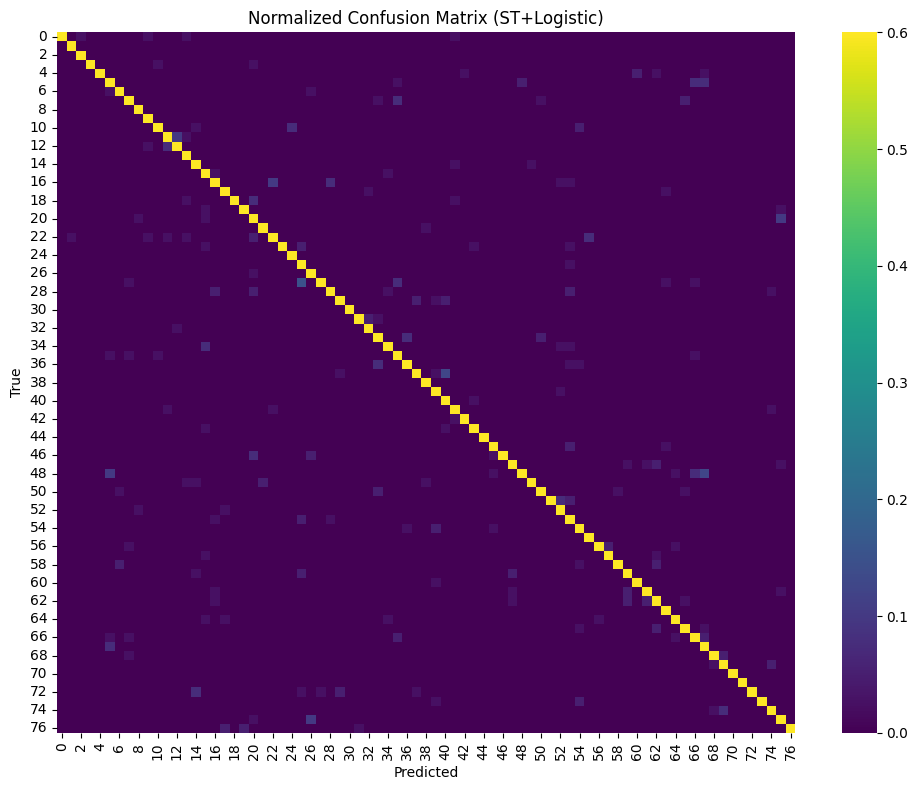

In [13]:
# BLOCK 10 - CONFUSION MATRIX (use model of your choice, e.g., ST+Logistic)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay

chosen = 'ST+Logistic'  # change if you want different matrix
preds = results[chosen]
cm = confusion_matrix(y_test, preds)
plt.figure(figsize=(10,8))
# show a normalized view (row-wise)
cm_norm = cm.astype('float') / (cm.sum(axis=1)[:, np.newaxis] + 1e-9)
sns.heatmap(cm_norm, cmap='viridis', vmax=0.6)
plt.title(f'Normalized Confusion Matrix ({chosen})')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()


In [14]:
# BLOCK 11 - ERROR ANALYSIS (sample some misclassifications)
import numpy as np
def show_misclassified(y_true, y_pred, texts, n=10):
    mis_idx = np.where(y_true != y_pred)[0]
    if len(mis_idx)==0:
        print("No misclassifications.")
        return
    print(f"Total misclassified: {len(mis_idx)}. Showing up to {n} examples:")
    sample = np.random.choice(mis_idx, size=min(n, len(mis_idx)), replace=False)
    for i in sample:
        print("\n---")
        print("Text:", texts[i])
        print("True label:", int(y_true[i]), "Pred:", int(y_pred[i]))

show_misclassified(y_test, results['ST+Logistic'], df_test['text'].tolist(), n=8)


Total misclassified: 283. Showing up to 8 examples:

---
Text: Good morning. I tried to make a purchase with my credit card last night and again this morning. Both times it was declined. Can you investigate?
True label: 27 Pred: 25

---
Text: Trouble transferring transaction contact for help
True label: 27 Pred: 35

---
Text: If I want to exchange currency, will there be extras?
True label: 31 Pred: 33

---
Text: When will my funds transfer?
True label: 66 Pred: 67

---
Text: where is theft-top option?
True label: 4 Pred: 42

---
Text: My card is being declined online. Could you tell me what might be broken or wrong with the account?
True label: 27 Pred: 25

---
Text: How do I cancel my card? There are charges on my account that I didn't make.
True label: 20 Pred: 15

---
Text: I want to order another crad
True label: 39 Pred: 52


In [15]:
# BLOCK 12 - SAVE ARTIFACTS
import joblib
art_dir = os.path.join(project_dir, "artifacts")
os.makedirs(art_dir, exist_ok=True)

joblib.dump(tfidf, os.path.join(art_dir, "tfidf_vectorizer.pkl"))
joblib.dump(models['LogisticRegression'], os.path.join(art_dir, "model_tfidf_lr.pkl"))
joblib.dump(models['LinearSVC'], os.path.join(art_dir, "model_tfidf_svm.pkl"))
joblib.dump(models['RandomForest'], os.path.join(art_dir, "model_tfidf_rf.pkl"))
joblib.dump(models['ST+Logistic'], os.path.join(art_dir, "model_st_logistic.pkl"))

# sentence-transformers has its own save method if you want to store model locally; it's OK to reload by name
print("Saved artifacts to", art_dir)


Saved artifacts to /content/drive/MyDrive/GenAI_Capstone/artifacts


In [18]:
# BLOCK A - BoW Baseline
from sklearn.feature_extraction.text import CountVectorizer

bow = CountVectorizer(max_features=10000, stop_words="english")
X_train_bow = bow.fit_transform(df_train["clean_text"])
X_test_bow = bow.transform(df_test["clean_text"])

from sklearn.linear_model import LogisticRegression
bow_lr = LogisticRegression(max_iter=2000)
bow_lr.fit(X_train_bow, y_train)

bow_pred = bow_lr.predict(X_test_bow)

print("BoW + LR Accuracy:", accuracy_score(y_test, bow_pred))
print(classification_report(y_test, bow_pred, zero_division=0))


BoW + LR Accuracy: 0.8438311688311688
              precision    recall  f1-score   support

           0       0.95      0.93      0.94        40
           1       0.97      0.97      0.97        40
           2       0.98      1.00      0.99        40
           3       0.88      0.88      0.88        40
           4       1.00      0.88      0.93        40
           5       0.65      0.75      0.70        40
           6       0.84      0.90      0.87        40
           7       0.94      0.80      0.86        40
           8       0.93      0.93      0.93        40
           9       1.00      0.97      0.99        40
          10       0.74      0.62      0.68        40
          11       0.76      0.85      0.80        40
          12       0.79      0.82      0.80        40
          13       0.86      0.93      0.89        40
          14       0.64      0.88      0.74        40
          15       0.81      0.85      0.83        40
          16       0.77      0.75      0.76

In [22]:
!pip install gensim


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 20.4 MB/s eta 0:00:00


In [23]:
# BLOCK B - Word2Vec Embeddings
from gensim.models import Word2Vec
import numpy as np

sentences = [txt.split() for txt in df_train["clean_text"]]
w2v_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1)

def embed_w2v(sentence):
    words = sentence.split()
    vecs = [w2v_model.wv[w] for w in words if w in w2v_model.wv]
    if not vecs:
        return np.zeros(100)
    return np.mean(vecs, axis=0)

X_train_w2v = np.vstack(df_train["clean_text"].apply(embed_w2v))
X_test_w2v = np.vstack(df_test["clean_text"].apply(embed_w2v))

w2v_lr = LogisticRegression(max_iter=2000)
w2v_lr.fit(X_train_w2v, y_train)

w2v_pred = w2v_lr.predict(X_test_w2v)

print("Word2Vec + LR Accuracy:", accuracy_score(y_test, w2v_pred))
print(classification_report(y_test, w2v_pred, zero_division=0))


Word2Vec + LR Accuracy: 0.2762987012987013
              precision    recall  f1-score   support

           0       0.18      0.33      0.23        40
           1       0.38      0.20      0.26        40
           2       0.21      0.15      0.17        40
           3       1.00      0.03      0.05        40
           4       0.17      0.10      0.13        40
           5       0.26      0.17      0.21        40
           6       0.22      0.30      0.26        40
           7       0.22      0.20      0.21        40
           8       0.19      0.30      0.23        40
           9       0.35      0.40      0.37        40
          10       0.00      0.00      0.00        40
          11       0.02      0.03      0.02        40
          12       0.10      0.07      0.09        40
          13       0.20      0.30      0.24        40
          14       0.50      0.17      0.26        40
          15       0.36      0.57      0.44        40
          16       0.31      0.28     

In [21]:
# BLOCK C - GloVe 100d
import numpy as np

# download if not available
!wget -q http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

glove_path = "glove.6B.50d.txt"

# load GloVe dict
glove = {}
with open(glove_path, "r", encoding="utf8") as f:
    for line in f:
        values = line.split()
        glove[values[0]] = np.asarray(values[1:], dtype="float32")

def embed_glove(sentence):
    words = sentence.split()
    vecs = [glove[w] for w in words if w in glove]
    if not vecs:
        return np.zeros(100)
    return np.mean(vecs, axis=0)

X_train_glove = np.vstack(df_train["clean_text"].apply(embed_glove))
X_test_glove = np.vstack(df_test["clean_text"].apply(embed_glove))

glove_lr = LogisticRegression(max_iter=2000)
glove_lr.fit(X_train_glove, y_train)

glove_pred = glove_lr.predict(X_test_glove)

print("GloVe + LR Accuracy:", accuracy_score(y_test, glove_pred))
print(classification_report(y_test, glove_pred, zero_division=0))


^C
replace glove.6B.50d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

KeyboardInterrupt: 

In [ ]:
# BLOCK D - BERT CLS embeddings (not fine-tuned)
from transformers import AutoTokenizer, AutoModel
import torch

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
bert_model = AutoModel.from_pretrained("bert-base-uncased")

def embed_bert(text):
    tokens = tokenizer(
        text,
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=64
    )
    with torch.no_grad():
        outputs = bert_model(**tokens)
    cls_vec = outputs.last_hidden_state[:,0,:].squeeze().numpy()
    return cls_vec

X_train_bert = np.vstack(df_train["text"].apply(embed_bert))
X_test_bert = np.vstack(df_test["text"].apply(embed_bert))

bert_lr = LogisticRegression(max_iter=2000)
bert_lr.fit(X_train_bert, y_train)

bert_pred = bert_lr.predict(X_test_bert)

print("BERT (CLS) + LR Accuracy:", accuracy_score(y_test, bert_pred))
print(classification_report(y_test, bert_pred, zero_division=0))


In [ ]:
# BLOCK E - MODEL COMPARISON SUMMARY

from sklearn.metrics import accuracy_score, f1_score

results_summary = {
    "BoW + LR": accuracy_score(y_test, bow_pred),
    "TF-IDF + LR": accuracy_score(y_test, results["LogisticRegression"]),
    "TF-IDF + SVM": accuracy_score(y_test, results["LinearSVC"]),
    "TF-IDF + RandomForest": accuracy_score(y_test, results["RandomForest"]),
    "Word2Vec + LR": accuracy_score(y_test, w2v_pred),
    "GloVe + LR": accuracy_score(y_test, glove_pred),
    "ST (MiniLM) + LR": accuracy_score(y_test, results["ST+Logistic"]),
    "BERT (CLS) + LR": accuracy_score(y_test, bert_pred)
}

import pandas as pd
df_results = pd.DataFrame(results_summary, index=["Accuracy"]).T
df_results = df_results.sort_values(by="Accuracy", ascending=False)
df_results


In [ ]:
# BLOCK F - BARPLOT OF MODEL ACCURACY
plt.figure(figsize=(10,6))
sns.barplot(
    x=df_results["Accuracy"].values,
    y=df_results.index,
)
plt.title("Model Comparison - Accuracy")
plt.xlabel("Accuracy")
plt.ylabel("Model")
plt.tight_layout()
plt.show()
